In [1]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import lightgbm as lgb
from sklearn import metrics
from sklearn.model_selection import train_test_split
import shap
import pickle
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import xgboost
from xgboost import XGBClassifier
import os
from sklearn.metrics import precision_recall_fscore_support
import catboost
from catboost import *

import warnings
warnings.filterwarnings("ignore")


sns.set_theme(style="whitegrid")
sns.set_style("whitegrid", {'axes.grid': False})

plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']




In [2]:
# Load and process data function
def dataloader(filepath):
    raw_data = pd.read_csv(filepath)
    med_columns = raw_data.columns[raw_data.columns.str.contains('Med_')]
    raw_data[med_columns] = raw_data[med_columns].fillna(0)
    columns_to_rename = raw_data.columns[65:273]
    new_column_names = [col.rsplit('_', 1)[0] for col in columns_to_rename]
    raw_data.rename(columns=dict(zip(columns_to_rename, new_column_names)), inplace=True)
    filtered_df = raw_data[raw_data['Is transferred to ICU'] == 1].drop('Is transferred to ICU', axis=1, errors='ignore')
    transform_dtypes_data = filtered_df.copy().iloc[:, 2:]
    category_columns_1 = transform_dtypes_data.columns[
        transform_dtypes_data.columns.str.contains('Med_') | transform_dtypes_data.columns.str.startswith('Diagnosis_')
    ]
    transform_dtypes_data[category_columns_1] = transform_dtypes_data[category_columns_1].applymap(lambda x: 0 if x == 0.0 else 1)
    category_columns_2 = ['Gender', 'Insurance', 'Race', 'triage_Acuity', 'Arrival transport']
    transform_dtypes_data[category_columns_1] = transform_dtypes_data[category_columns_1].astype('category')
    transform_dtypes_data[category_columns_2] = transform_dtypes_data[category_columns_2].astype('category')
    # print(transform_dtypes_data.dtypes)

    def remove_outliers(df):
        for column in df.columns:
            if pd.api.types.is_numeric_dtype(df[column]):
                lower_bound = df[column].quantile(0.01)
                upper_bound = df[column].quantile(0.99)
                df[column] = df[column].apply(lambda v: lower_bound if v < lower_bound else upper_bound if v > upper_bound else v)
            if column == 'Age':
                df[column] = df[column].apply(lambda v: 91 if v > 91 else v)
        return df
    
    data = remove_outliers(transform_dtypes_data)
    X = data.iloc[:, :-1]
    y = data.iloc[:, -1].squeeze()  # Ensure y is a 1D Series
    return X, y

# Feature selection function
def select_features(X, selected_features):
    print(f'Selected feature count: {len(selected_features)}')
    return X[selected_features]


def fillna_mean(X):
    for column in list(X.columns[X.isnull().sum()>0]):
        mean_val = X[column].mean()
        X[column].fillna(mean_val,inplace=True)
    return X


In [3]:
cd = '/Users/hnwang/bmc/ihm_icu/' 
save_path = cd +'/fs_imp_step2-1/ML_models_compare/'

raw_data_path = '/Users/hnwang/ihm/without_fillna/alldata.csv'
X, y = dataloader(raw_data_path)

fs1 = pd.read_excel('/Users/hnwang/bmc/ihm_icu/fs_corr_step1' + '/significantPvalue_ihm.xlsx') #encoding_errors='ignore',,encoding="utf-8"
selected_features=fs1['ID'].tolist()
X_fs1 = select_features(X, selected_features)

Selected feature count: 168


## step 1: get model importance and shap importance

In [7]:
save_path = '/Users/hnwang/bmc/ihm_icu/fs_auc_step2-2/get_4treeModels_weight_importance/'

def model_10cv_XGBoost_imp0(X,y):
    #import xgboost
    #from sklearn.model_selection import StratifiedKFold
    #from sklearn import metrics
    skf = StratifiedKFold(n_splits=10)#, random_state=0
    t = y.values
    allAUC = []
    allY = []
    allPY = []
    allimp = []
    for train_index, test_index in skf.split(np.zeros(len(t)),t):
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        D_train = xgboost.DMatrix(X_train,label=y_train, enable_categorical=True)
        D_test = xgboost.DMatrix(X_test,label=y_test, enable_categorical=True)
        ###
        params = {
            "eta": 0.01,
            "booster": "gbtree",
            "objective": "binary:logistic",
            "eval_metric":"auc",
            "min_child_weight": 150,

        }
        steps = 1000  # The number of training iterations
        model = xgboost.train(params, D_train, steps)#
        importances = model.get_score(importance_type='gain')#or 'total_gain' this is a dictory, like {'age':24,} so do not add columns name
        #print(importances)
        y_tepred = model.predict(D_test)        
        auc_te = metrics.roc_auc_score(y_test, y_tepred)        
        print('auc_te = ', auc_te)
        allimp.append(importances)
        allAUC.append(auc_te)
        allY.extend(y_test)
        allPY.extend(y_tepred)
    meanAUC = np.mean(allAUC)
    print('====XGBoost model: meanAUC={}'.format(meanAUC))
    print('====XGBoost model: 95% CI=[{}, {}]'.format(np.percentile(allAUC,2.5), np.percentile(allAUC,97.5))) 
    #print('====XGBoost model: meanAUC={}'.format(meanAUC),file=log)
    #print('====XGBoost model: 95% CI=[{}, {}]'.format(np.percentile(allAUC,2.5), np.percentile(allAUC,97.5)),file=log)
    #predict_result = pd.DataFrame({'y_test':allY,'y_tepred':allPY}) 
    df_imp = pd.DataFrame(allimp,index=['k'+str(i+1) for i in range(10)])# k fold cv
    if os.path.exists(save_path+'/XGBoost/')==False:
        os.makedirs(save_path+'/XGBoost/')
    #predict_result.to_csv(save_path+'/XGBoost/predict_result_XGBoost.csv',index=False)
    df_imp.to_csv(save_path+'/XGBoost/importances_XGBoost.csv',index=True)     
    return df_imp   


result = model_10cv_XGBoost_imp0(X_fs1, y)


auc_te =  0.8072824772041561
auc_te =  0.7799681073353129
auc_te =  0.7855092785181147
auc_te =  0.8038350092522198
auc_te =  0.7762624379001526
auc_te =  0.8116025705392109
auc_te =  0.8023252478017013
auc_te =  0.8026207554816909
auc_te =  0.7986891229010062
auc_te =  0.7951805355917123
====XGBoost model: meanAUC=0.7963275542525279
====XGBoost model: 95% CI=[0.7770962135230637, 0.8106305495388236]


In [9]:
def model_10cv_LightGBM_imp(X,y):
    import lightgbm as lgb
    from sklearn.model_selection import StratifiedKFold
    from sklearn import metrics
    skf = StratifiedKFold(n_splits=10)#, random_state=0
    t = y.values
    allAUC = []
    allY = []
    allPY = []
    allimp = []
    for train_index, test_index in skf.split(np.zeros(len(t)),t):
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        d_train = lgb.Dataset(X_train,label=y_train)
        d_test = lgb.Dataset(X_test,label=y_test)
        ###
        params = {
            "learning_rate": 0.01,
            "boosting_type": "gbdt",
            "objective": "binary",
            "metric": ['auc', 'binary_logloss'],
            'max_depth': 5,
            'verbosity': -1,
        }
        model = lgb.train(params, d_train, 1000)
        importances = model.feature_importance(importance_type='gain')
        # print(importances)
        y_tepred = model.predict(X_test)
        auc_te = metrics.roc_auc_score(y_test, y_tepred)        
        print('auc_te = ', auc_te)
        allimp.append(importances)
        allAUC.append(auc_te)
        allY.extend(y_test)
        allPY.extend(y_tepred)
    meanAUC = np.mean(allAUC)
    print('====LightGBM model: meanAUC={}'.format(meanAUC))
    print('====LightGBM model: 95% CI=[{}, {}]'.format(np.percentile(allAUC,2.5), np.percentile(allAUC,97.5))) 
    #print('====LightGBM model: meanAUC={}'.format(meanAUC),file=log)
    #print('====LightGBM model: 95% CI=[{}, {}]'.format(np.percentile(allAUC,2.5), np.percentile(allAUC,97.5)),file=log)
    #predict_result = pd.DataFrame({'y_test':allY,'y_tepred':allPY}) 
    df_imp = pd.DataFrame(allimp,columns=X.columns,index=['k'+str(i+1) for i in range(10)])# k fold cv
    if os.path.exists(save_path+'/LightGBM/')==False:
        os.makedirs(save_path+'/LightGBM/')
    #predict_result.to_csv(save_path+'/LightGBM/predict_result_LightGBM.csv',index=False) 
    df_imp.to_csv(save_path+'/LightGBM/importances_LightGBM.csv',index=True)   
    return df_imp    

result = model_10cv_LightGBM_imp(X_fs1, y)  

auc_te =  0.8086631379130628
auc_te =  0.7899734148102457
auc_te =  0.788855737093512
auc_te =  0.8077008592371581
auc_te =  0.7791122172335144
auc_te =  0.821256437106422
auc_te =  0.8048881365981476
auc_te =  0.8042803114785155
auc_te =  0.8017540544871411
auc_te =  0.7940564483147061
====LightGBM model: meanAUC=0.8000540754272425
====LightGBM model: 95% CI=[0.7813045092020139, 0.8184229447879162]


In [8]:
def model_10cv_Catboost_imp(X,y):
    #import catboost
    #from catboost import *
    #from sklearn import metrics
    skf = StratifiedKFold(n_splits=10)
    cat_features = X.select_dtypes(['category']).columns.tolist()
    model = CatBoostClassifier(iterations=1000, learning_rate=0.01, cat_features=cat_features, verbose=0)
    ## note X,y is dataFrame, not array, so .split(X,y) is not right
    t = y.values
    allAUC = []
    allY = []
    allPY = []
    allimp = []
    for train_index, test_index in skf.split(np.zeros(len(t)),t):
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train,y_train)
        importances = model.feature_importances_
        probs = model.predict_proba(X_test)
        y_tepred = probs[:,1]
        auc_te = metrics.roc_auc_score(y_test, y_tepred)        
        print('auc_te = ', auc_te)
        allimp.append(importances)
        allAUC.append(auc_te)
        allY.extend(y_test)
        allPY.extend(y_tepred)
    meanAUC = np.mean(allAUC)
    print('====Catboost model: meanAUC={}'.format(meanAUC))
    print('====Catboost model: 95% CI=[{}, {}]'.format(np.percentile(allAUC,2.5), np.percentile(allAUC,97.5))) 
    #print('====Catboost model: meanAUC={}'.format(meanAUC),file=log)
    #print('====Catboost model: 95% CI=[{}, {}]'.format(np.percentile(allAUC,2.5), np.percentile(allAUC,97.5)),file=log)
    #predict_result = pd.DataFrame({'y_test':allY,'y_tepred':allPY}) 
    df_imp = pd.DataFrame(allimp,columns=X.columns,index=['k'+str(i+1) for i in range(10)])# k fold cv
    if os.path.exists(save_path+'/Catboost/')==False:
        os.makedirs(save_path+'/Catboost/')
    #predict_result.to_csv(save_path+'/Catboost/predict_result_Catboost.csv',index=False) 
    df_imp.to_csv(save_path+'/Catboost/importances_Catboost.csv',index=True)     
    return df_imp    

result = model_10cv_Catboost_imp(X_fs1, y)

auc_te =  0.8057081653828316
auc_te =  0.7870602804833149
auc_te =  0.787954422656702
auc_te =  0.8095859691401412
auc_te =  0.776427399958879
auc_te =  0.8103701366077107
auc_te =  0.8057727157536374
auc_te =  0.8048187078965606
auc_te =  0.8030240339426525
auc_te =  0.7942525656694178
====Catboost model: meanAUC=0.7984974397491849
====Catboost model: 95% CI=[0.7788197980768771, 0.8101936989275076]


In [44]:
save_path = '/Users/hnwang/bmc/ihm_icu/fs_auc_step2-2/get_4treeModels_shap_importance/'

def get_shap_imp(model,X):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    #warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
    b = pd.DataFrame(shap_values[1],columns=X.columns)
    #b.to_csv(new_save_path + '/shap_values.csv',index=False)    
    #b.to_pickle(save_path+'/shap_values.pkl')
    '''
    c = {'shap_values':b,'expected_value':explainer.expected_value[1]}  
    #print(explainer.expected_value)  
    np.save(save_path+'/raw_shap_values/'+'shap_values_expected_value_t='+str(t)+'_col='+col+'_fname='+fname+'.npy',c)   
    '''    
    ## save feature importance
    imp = b.abs().mean(0)
    '''
    df = pd.DataFrame()
    df['feature name'] = temp.index
    df['importance'] = temp.values
    dff = df.sort_values('importance',ascending=False)
    #df.plot.barh(x = 'feature name')
    dff.to_csv(new_save_path+'/shap_importance.csv',index=True)
    '''
    return imp


In [55]:
def model_10cv_XGBoost_imp0(X,y):
    #import xgboost
    #from sklearn.model_selection import StratifiedKFold
    #from sklearn import metrics
    skf = StratifiedKFold(n_splits=10)#, random_state=0
    t = y.values
    allAUC = []
    allY = []
    allPY = []
    allimp = []
    for train_index, test_index in skf.split(np.zeros(len(t)),t):
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        D_train = xgboost.DMatrix(X_train,label=y_train, enable_categorical=True)
        D_test = xgboost.DMatrix(X_test,label=y_test, enable_categorical=True)
        ###
        params = {
            "eta": 0.01,
            "booster": "gbtree",
            "objective": "binary:logistic",
            "eval_metric":"auc",
            "min_child_weight": 150,
        }
        steps = 1000  # The number of training iterations
        model = xgboost.train(params, D_train, steps, verbose_eval=False)#
        #importances = model.get_score(importance_type='weight')# this is a dictory, like {'age':24,} so do not add columns name
        #print(importances)
        #importances = get_shap_imp(model,X_train)
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(D_train)
        b = pd.DataFrame(shap_values,columns=X_train.columns)
        importances = b.abs().mean(0)
        y_tepred = model.predict(D_test)        
        auc_te = metrics.roc_auc_score(y_test, y_tepred)        
        print('auc_te = ', auc_te)
        allimp.append(importances)
        allAUC.append(auc_te)
        allY.extend(y_test)
        allPY.extend(y_tepred)
    meanAUC = np.mean(allAUC)
    print('====XGBoost model: meanAUC={}'.format(meanAUC))
    print('====XGBoost model: 95% CI=[{}, {}]'.format(np.percentile(allAUC,2.5), np.percentile(allAUC,97.5))) 
    #print('====XGBoost model: meanAUC={}'.format(meanAUC),file=log)
    #print('====XGBoost model: 95% CI=[{}, {}]'.format(np.percentile(allAUC,2.5), np.percentile(allAUC,97.5)),file=log)
    #predict_result = pd.DataFrame({'y_test':allY,'y_tepred':allPY}) 
    df_imp = pd.DataFrame(allimp,index=['k'+str(i+1) for i in range(10)])# k fold cv
    if os.path.exists(save_path+'/XGBoost/')==False:
        os.makedirs(save_path+'/XGBoost/')
    #predict_result.to_csv(save_path+'/XGBoost/predict_result_XGBoost.csv',index=False)
    df_imp.to_csv(save_path+'/XGBoost/importances_XGBoost.csv',index=True)     
    return df_imp   


result = model_10cv_XGBoost_imp0(X_fs1,y)

auc_te =  0.8072824772041561
auc_te =  0.7799681073353129
auc_te =  0.7855092785181147
auc_te =  0.8038350092522198
auc_te =  0.7762624379001526
auc_te =  0.8116025705392109
auc_te =  0.8023252478017013
auc_te =  0.8026207554816909
auc_te =  0.7986891229010062
auc_te =  0.7951805355917123
====XGBoost model: meanAUC=0.7963275542525279
====XGBoost model: 95% CI=[0.7770962135230637, 0.8106305495388236]


In [53]:

def model_10cv_Catboost_imp(X,y):
    #import catboost
    #from catboost import *
    #from sklearn import metrics
    skf = StratifiedKFold(n_splits=10)
    cat_features = X.select_dtypes(['category']).columns.tolist()
    model = CatBoostClassifier(iterations=1000, learning_rate=0.01, cat_features=cat_features, verbose=0)
    ## note X,y is dataFrame, not array, so .split(X,y) is not right
    t = y.values
    allAUC = []
    allY = []
    allPY = []
    allimp = []
    for train_index, test_index in skf.split(np.zeros(len(t)),t):
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train,y_train)
        #importances = model.feature_importances_
        #importances = get_shap_imp(model,X_train)
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_train)
        b = pd.DataFrame(shap_values,columns=X_train.columns)
        importances = b.abs().mean(0)
        probs = model.predict_proba(X_test)
        y_tepred = probs[:,1]
        auc_te = metrics.roc_auc_score(y_test, y_tepred)        
        print('auc_te = ', auc_te)
        allimp.append(importances)
        allAUC.append(auc_te)
        allY.extend(y_test)
        allPY.extend(y_tepred)
    meanAUC = np.mean(allAUC)
    print('====Catboost model: meanAUC={}'.format(meanAUC))
    print('====Catboost model: 95% CI=[{}, {}]'.format(np.percentile(allAUC,2.5), np.percentile(allAUC,97.5))) 
    #print('====Catboost model: meanAUC={}'.format(meanAUC),file=log)
    #print('====Catboost model: 95% CI=[{}, {}]'.format(np.percentile(allAUC,2.5), np.percentile(allAUC,97.5)),file=log)
    #predict_result = pd.DataFrame({'y_test':allY,'y_tepred':allPY}) 
    df_imp = pd.DataFrame(allimp,columns=X.columns,index=['k'+str(i+1) for i in range(10)])# k fold cv
    if os.path.exists(save_path+'/Catboost/')==False:
        os.makedirs(save_path+'/Catboost/')
    #predict_result.to_csv(save_path+'/Catboost/predict_result_Catboost.csv',index=False) 
    df_imp.to_csv(save_path+'/Catboost/importances_Catboost.csv',index=True)     
    return df_imp    

result = model_10cv_Catboost_imp(X_fs1, y)

auc_te =  0.8057081653828316
auc_te =  0.7870602804833149
auc_te =  0.787954422656702
auc_te =  0.8095859691401412
auc_te =  0.776427399958879
auc_te =  0.8103701366077107
auc_te =  0.8057727157536374
auc_te =  0.8048187078965606
auc_te =  0.8030240339426525
auc_te =  0.7942525656694178
====Catboost model: meanAUC=0.7984974397491849
====Catboost model: 95% CI=[0.7788197980768771, 0.8101936989275076]


In [49]:
def model_10cv_LightGBM_imp(X,y):
    #import lightgbm as lgb
    #from sklearn.model_selection import StratifiedKFold
    #from sklearn import metrics
    skf = StratifiedKFold(n_splits=10)#, random_state=0
    t = y.values
    allAUC = []
    allY = []
    allPY = []
    allimp = []
    for train_index, test_index in skf.split(np.zeros(len(t)),t):
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        d_train = lgb.Dataset(X_train,label=y_train)
        d_test = lgb.Dataset(X_test,label=y_test)
        ###
        # params = {
        #     "max_bin": 100,
        #     "learning_rate": 0.01,
        #     "boosting_type": "gbdt",
        #     "objective": "binary",
        #     "metric": ['auc','binary_logloss'],
        #     "num_leaves": 50,
        #     "verbose": -1,
        #     "min_data": 10,
        #     "boost_from_average": True
        # }
        # model = lgb.train(params, d_train, 500)
        params = {
            "learning_rate": 0.01,
            "boosting_type": "gbdt",
            "objective": "binary",
            "metric": ['auc', 'binary_logloss'],
            'max_depth': 5,
            'verbosity': -1,
        }
        model = lgb.train(params, d_train, 1000)
        #importances = model.feature_importance()
        # print('========begin')
        #importances = get_shap_imp(model,X_train)
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_train)
        b = pd.DataFrame(shap_values[1],columns=X_train.columns)
        importances = b.abs().mean(0)
        # print(importances)
        y_tepred = model.predict(X_test, num_iteration=model.best_iteration)
        auc_te = metrics.roc_auc_score(y_test, y_tepred)        
        print('auc_te = ', auc_te)
        allimp.append(importances)
        allAUC.append(auc_te)
        allY.extend(y_test)
        allPY.extend(y_tepred)
    meanAUC = np.mean(allAUC)
    print('====LightGBM model: meanAUC={}'.format(meanAUC))
    print('====LightGBM model: 95% CI=[{}, {}]'.format(np.percentile(allAUC,2.5), np.percentile(allAUC,97.5))) 
    #print('====LightGBM model: meanAUC={}'.format(meanAUC),file=log)
    #print('====LightGBM model: 95% CI=[{}, {}]'.format(np.percentile(allAUC,2.5), np.percentile(allAUC,97.5)),file=log)
    #predict_result = pd.DataFrame({'y_test':allY,'y_tepred':allPY}) 
    df_imp = pd.DataFrame(allimp,columns=X.columns,index=['k'+str(i+1) for i in range(10)])# k fold cv
    if os.path.exists(save_path+'/LightGBM/')==False:
        os.makedirs(save_path+'/LightGBM/')
    #predict_result.to_csv(save_path+'/LightGBM/predict_result_LightGBM.csv',index=False) 
    df_imp.to_csv(save_path+'/LightGBM/importances_LightGBM.csv',index=True)   
    return df_imp    

result = model_10cv_LightGBM_imp(X_fs1, y)  

auc_te =  0.8086631379130628
auc_te =  0.7899734148102457
auc_te =  0.788855737093512
auc_te =  0.8077008592371581
auc_te =  0.7791122172335144
auc_te =  0.821256437106422
auc_te =  0.8048881365981476
auc_te =  0.8042803114785155
auc_te =  0.8017540544871411
auc_te =  0.7940564483147061
====LightGBM model: meanAUC=0.8000540754272425
====LightGBM model: 95% CI=[0.7813045092020139, 0.8184229447879162]


## Step 2: get similarity data and plot radar 

In [20]:
## input data
cd = '/Users/hnwang/bmc/ihm_icu/fs_auc_step2-2/' 
search_path1 = cd + '/get_4treeModels_weight_importance/'
search_path2 = cd + '/get_4treeModels_shap_importance/'
save_path = cd +'/plot_similarity_figures/step1_get_similarity_data/'

methods = ['LightGBM','XGBoost','Catboost']

#K = 400 # top K


def normalize(data):
    min_val = np.min(data)
    max_val = np.max(data)
    normalized_data = (data-min_val)/(max_val-min_val)
    return normalized_data

def threshold(data,threshold_value):
    data[data<=threshold_value] = 0
    return data


threshold_value = 0.01


def get_data_SHAP(method):
    data0 = pd.read_csv(search_path2+method+'/importances_'+method+'.csv',index_col=0)
    data = normalize(data0.iloc[0,:])
    data = threshold(data,threshold_value)
    data1 = data.sort_values(ascending=False) 
    data1.to_csv(save_path+method+'_shap_imp.csv', header=False)
    return data1

def get_data_weight(method):
    data0 = pd.read_csv(search_path1+method+'/importances_'+method+'.csv',index_col=0)
    data = normalize(data0.iloc[0,:])
    data = threshold(data,threshold_value)
    data1 = data.sort_values(ascending=False) 
    data1.to_csv(save_path+method+'_imp.csv', header=False)
    return data1




#method = methods[0]
for method in methods:
    data1 = get_data_SHAP(method)
    data1 = get_data_weight(method)

16
16
16
16
16
16


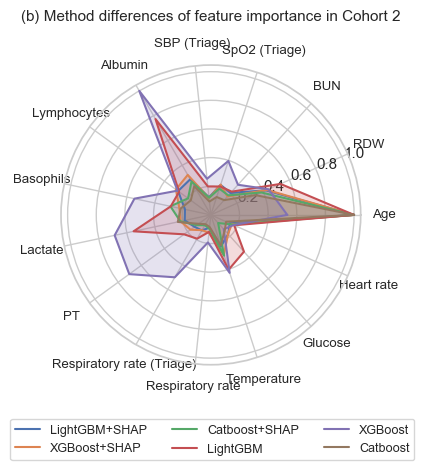

In [8]:
cd = '/Users/hnwang/bmc/ihm_icu/fs_auc_step2-2/plot_similarity_figures/'
search_path = cd + '/step1_get_similarity_data/'
save_path = cd + '/step2_plot_similarity_figure/'

#####
#利用plot_importance_auc_trend筛选出的17个特征
features = [
    "Age",
    "Lab_RDW",
    "Lab_Urea Nitrogen",
    "triage_SpO2",
    "triage_SBP",
    "Lab_Albumin",
    "Lab_Lymphocytes",
    "Lab_Basophils",
    "Lab_Lactate",
    "Lab_PT",
    # "Lab_RDW-SD",
    "triage_RespiratoryRate",
    "vitalsigns_RespiratoryRate",
    "vitalsigns_Temperature",
    "Lab_Glucose",
    "vitalsigns_HeartRate"
]
# 特征名称
featureNames = [
    "Age",
    "RDW",
    "BUN",
    "SpO2 (Triage)",
    "SBP (Triage)",
    "Albumin",
    "Lymphocytes",
    "Basophils",
    "Lactate",
    "PT",
    # "RDW-SD",
    "Respiratory rate (Triage)",
    "Respiratory rate",
    "Temperature",
    "Glucose",
    "Heart rate"
]


methods = ["LightGBM_shap", "XGBoost_shap", "Catboost_shap", "LightGBM", "XGBoost", "Catboost"]

methodNames = ["LightGBM+SHAP", "XGBoost+SHAP", "Catboost+SHAP", "LightGBM", "XGBoost", "Catboost"]

def get_weight(method,features):
    temp = pd.read_csv(search_path+method+'_imp.csv',header=None)
    temp.columns = ['Name', 'value']    
    temp1 = temp[temp['Name'].isin(features)]
    temp1['Name'] = pd.Categorical(temp1['Name'],categories=features,ordered=True)
    temp2 = temp1.sort_values('Name') 
    data = temp2['value']
    return data
    

# 特征权重值

weights_method1 = get_weight(methods[0],features)
weights_method2 = get_weight(methods[1],features)
weights_method3 = get_weight(methods[2],features)
weights_method4 = get_weight(methods[3],features)
weights_method5 = get_weight(methods[4],features)
weights_method6 = get_weight(methods[5],features)

# 角度
angles = np.linspace(0, 2 * np.pi, len(features), endpoint=False).tolist()
angles += angles[:1]

# 特征权重值循环
weights_all = [weights_method1, weights_method2, weights_method3, weights_method4, weights_method5, weights_method6]


# 绘制雷达图
fig, ax = plt.subplots(figsize=(5, 5), subplot_kw={'projection': 'polar'})
for weights, method in zip(weights_all, methodNames):
    weights = np.concatenate((weights,weights[:1]))
    print(len(weights))
    ax.plot(angles, weights, label=method)
    ax.fill(angles, weights, alpha=0.20)

# 设置角度标签
ax.set_xticks(angles[:-1])
ax.set_xticklabels(featureNames,fontsize=9.5)

# 设置标题
ax.set_title("(b) Method differences of feature importance in Cohort 2", fontsize=11,pad=12)

# 设置网格线
ax.grid(True)

# 设置图例
ax.legend(loc='upper right', bbox_to_anchor=(1.2, -0.16), ncol=3,fontsize=9)#,bbox_to_anchor=(1.3, 1) (1.00, -0.06),ncol=2

plt.tight_layout()
plt.savefig(save_path + '/radar_figure_MIMIC.png',dpi=300)
# 显示图形
plt.show()


## Step 3: get stability data and plot radar 

In [4]:
import pandas as pd
import numpy as np


## input data
cd = '/Users/hnwang/bmc/ihm_icu/fs_auc_step2-2/' 
search_path1 = cd + '/get_4treeModels_shap_importance/'
search_path2 = cd + '/get_4treeModels_weight_importance/'
save_path = cd +'/plot_stability_figures/step1-get stability/'

methods = ['LightGBM','XGBoost','Catboost']
K=100
##

def get_data(shapORweight,method):
    if shapORweight == 'shap':
        search_path = search_path1
    elif shapORweight == 'weight':
        search_path = search_path2
    else:
        print('wrong searhORweight input!')
    data = pd.read_csv(search_path+method+'/importances_'+method+'.csv',index_col=0)
    return data
    

#shapORweight = 'shap'
#method = methods[0]
#data = get_data(shapORweight,method)

def normalize(data):
    min_val = np.min(data)
    max_val = np.max(data)
    normalized_data = (data-min_val)/(max_val-min_val)
    return normalized_data


def threshold(data,threshold_value):
    data[data<=threshold_value] = 0
    return data


threshold_value = 0.01

def get_rank(data):
    a = data.iloc[0,:]
    a = normalize(a)
    a = threshold(a,threshold_value)
    #b = a.sort_values(ascending=False) 
    #c =  pd.Series(list(range(1,len(b)+1)),index=b.index)    
    for i in range(data.shape[0]):
        if i==0: 
            pass
        else:
            a1 = data.iloc[i,:]
            a1 = normalize(a1)
            a1 = threshold(a1,threshold_value)
            #b1 = a1.sort_values(ascending=False) 
            #d =  pd.Series(list(range(1,len(b1)+1)),index=b1.index)
            #c = pd.concat([c,d],axis=1) 
            a = pd.concat([a,a1],axis=1)
    colnames = ['Samples-1','Samples-2','Samples-3','Samples-4','Samples-5','Samples-6','Samples-7','Samples-8','Samples-9','Samples-10']
    a.columns = colnames
    a.to_csv(save_path+str(method)+'_'+str(shapORweight)+'_stability.csv',index_label='features')
    return a         

for shapORweight in ['weight','shap']:
    for method in methods:
        data = get_data(shapORweight,method)
        a = get_rank(data)


16
16
16
16
16
16


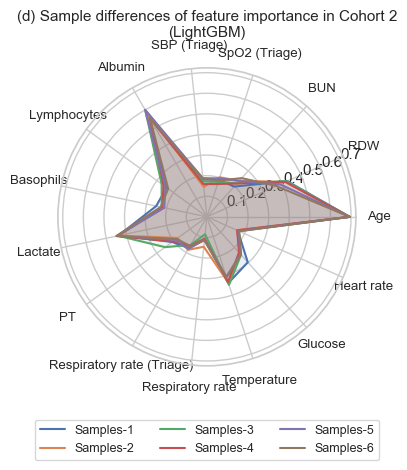

In [19]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns


cd = '/Users/hnwang/bmc/ihm_icu/fs_auc_step2-2' 
search_path = cd + '/plot_stability_figures/step1-get stability/'
save_path = cd +'/plot_stability_figures/step2-plot radar stability figure/'

#####
#利用plot_importance_auc_trend筛选出的17个特征
features = [
    "Age",
    "Lab_RDW",
    "Lab_Urea Nitrogen",
    "triage_SpO2",
    "triage_SBP",
    "Lab_Albumin",
    "Lab_Lymphocytes",
    "Lab_Basophils",
    "Lab_Lactate",
    "Lab_PT",
    # "Lab_RDW-SD",
    "triage_RespiratoryRate",
    "vitalsigns_RespiratoryRate",
    "vitalsigns_Temperature",
    "Lab_Glucose",
    "vitalsigns_HeartRate"
]
# 特征名称
featureNames = [
    "Age",
    "RDW",
    "BUN",
    "SpO2 (Triage)",
    "SBP (Triage)",
    "Albumin",
    "Lymphocytes",
    "Basophils",
    "Lactate",
    "PT",
    # "RDW-SD",
    "Respiratory rate (Triage)",
    "Respiratory rate",
    "Temperature",
    "Glucose",
    "Heart rate"
]


methods = ["LightGBM_shap", "XGBoost_shap", "Catboost_shap", "LightGBM_weight", "XGBoost_weight", "Catboost_weight"]

methodNames = ["LightGBM+SHAP", "XGBoost+SHAP", "Catboost+SHAP", "LightGBM", "XGBoost", "Catboost"]

def get_weight(method,features):
    temp = pd.read_csv(search_path+method+'_stability.csv')
    temp1 = temp[temp['features'].isin(features)]
    temp1['features'] = pd.Categorical(temp1['features'],categories=features,ordered=True)
    data = temp1.sort_values('features') 
    return data
    
method = methods[3]
data = get_weight(method,features)
# 特征权重值

weights_s1 = data.loc[:,'Samples-1']
weights_s2 = data.loc[:,'Samples-2']
weights_s3 = data.loc[:,'Samples-3']
weights_s4 = data.loc[:,'Samples-4']
weights_s5 = data.loc[:,'Samples-5']
weights_s6 = data.loc[:,'Samples-6']

# 角度
angles = np.linspace(0, 2 * np.pi, len(features), endpoint=False).tolist()
angles += angles[:1]

# 特征权重值循环
weights_all = [weights_s1, weights_s2, weights_s3, weights_s4, weights_s5, weights_s6]

sampleNames = ['Samples-1','Samples-2','Samples-3','Samples-4','Samples-5','Samples-6']
# 绘制雷达图
fig, ax = plt.subplots(figsize=(5, 5), subplot_kw={'projection': 'polar'})
for weights, method in zip(weights_all, sampleNames):
    weights = np.log1p(weights)  # use log1p to avoid log(0) issues
    weights = np.concatenate((weights,weights[:1]))
    print(len(weights))
    ax.plot(angles, weights, label=method)
    ax.fill(angles, weights, alpha=0.1)
# 设置角度标签
ax.set_xticks(angles[:-1])
ax.set_xticklabels(featureNames,fontsize=9.5)
# ax.set_yticks([0.1, 0.2, 0.3, 0.4])  # 选择显示的刻度值

# 设置标题
ax.set_title("(d) Sample differences of feature importance in Cohort 2\n(LightGBM)", fontsize=11,pad=2)
# 设置网格线
ax.grid(True)
# 设置图例
ax.legend(loc='upper right', bbox_to_anchor=(1.1, -0.16), ncol=3,fontsize=9)#,bbox_to_anchor=(1.3, 1) (1.00, -0.06),ncol=2
plt.tight_layout()
plt.savefig(save_path + '/stability_radar_figure_MIMIC.png',dpi=300)
# 显示图形
plt.show()
